In [144]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from sklearn.preprocessing import StandardScaler
from statsmodels.sandbox.regression.gmm import IV2SLS

In [161]:
data_ivdv = pd.read_csv('/Users/jinwens/Desktop/writing_sample_packet/GitHub/merged_data_ivdv.csv')
data_cv = pd.read_csv('/Users/jinwens/Desktop/writing_sample_packet/GitHub/merged_data_cv.csv')
df = pd.merge(data_ivdv, data_cv, on='week')

In [162]:
df['week_index'] = df.index + 1

In [163]:
df['weekly_counts'].unique()

array([ 0,  1,  6,  2, 22, 21, 56, 83, 41, 38, 33, 26, 25, 10, 19, 13, 14,
        3,  4,  8,  7,  5, 23, 12, 11])

In [164]:
df['xenophobic_weekly_counts'].sum()

46

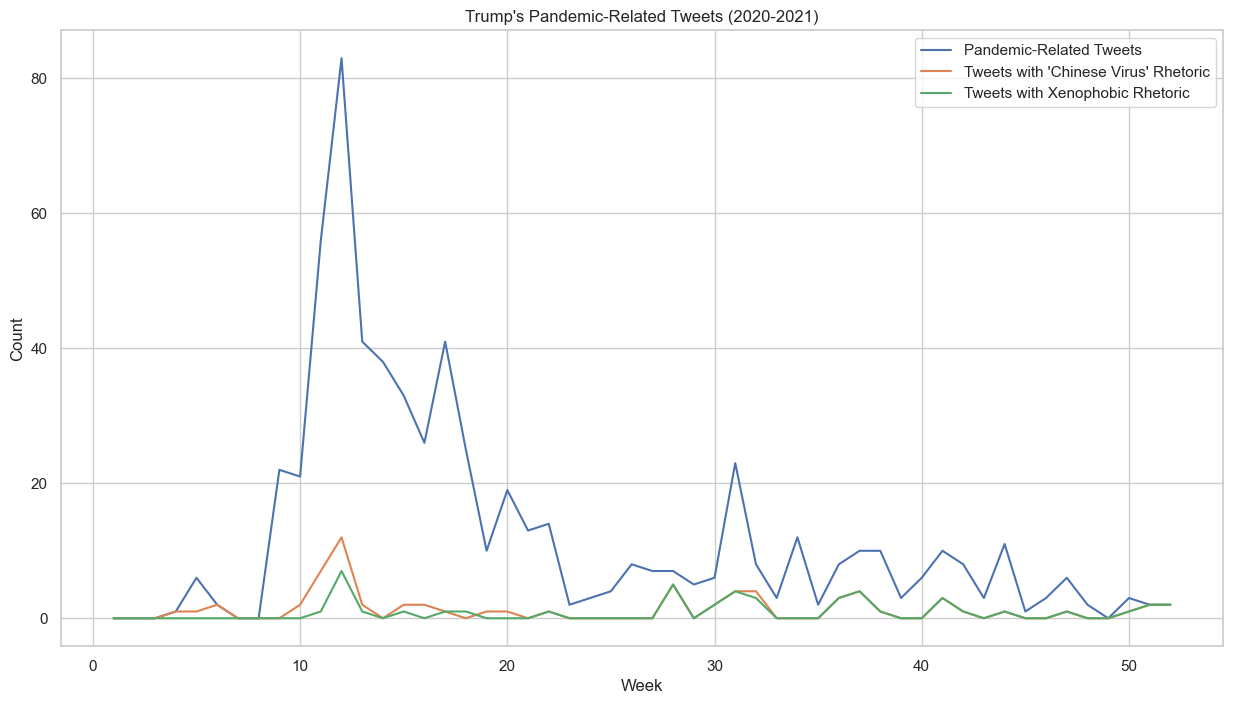

In [165]:
# Plot Web trend data
plt.figure(figsize=(15, 8))
plt.plot(df['week_index'], df['weekly_counts'], label='Pandemic-Related Tweets')
plt.plot(df['week_index'], df['china_weekly_counts'], label='Tweets with \'Chinese Virus\' Rhetoric')
plt.plot(df['week_index'], df['xenophobic_weekly_counts'], label='Tweets with Xenophobic Rhetoric')

plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Trump\'s Pandemic-Related Tweets (2020-2021)')

plt.legend()
plt.grid(True)
plt.show()


## Data Preparation: 
### Transformation 
**Log Transformation**: Apply a log transformation to create a variable named **web_trend**. 
This transformation will be:

$$
\text{web_trend} = \log(\text{china_virus} + \text{chinese_virus} + \text{wuhan_virus} - \min(\text{china_virus} + \text{chinese_virus} + \text{wuhan_virus}) + 1)
$$



Similarly, create a new variable named **youtube_trend**:
$$
\begin{align*}
\text{youtube_trend} &= \log(\text{china_virus_youtube} + \text{chinese_virus_youtube} + \text{wuhan_virus_youtube} \\
&\quad - \min(\text{china_virus_youtube} + \text{chinese_virus_youtube} + \text{wuhan_virus_youtube}) + 1)
\end{align*}
$$

In [166]:
df['web_trend'] = np.log(df['china_virus'] + df['chinese_virus'] + df['wuhan_virus'] - (df['china_virus'] + df['chinese_virus'] + df['wuhan_virus']).min() + 1)

In [167]:
df['web_trend'].std()

1.5236541950015283

In [168]:
df['youtube_trend'] = np.log(df['china_virus_youtube'] + df['chinese_virus_youtube'] + df['wuhan_virus_youtube'] - (df['china_virus_youtube'] + df['chinese_virus_youtube'] + df['wuhan_virus_youtube']).min() + 1)

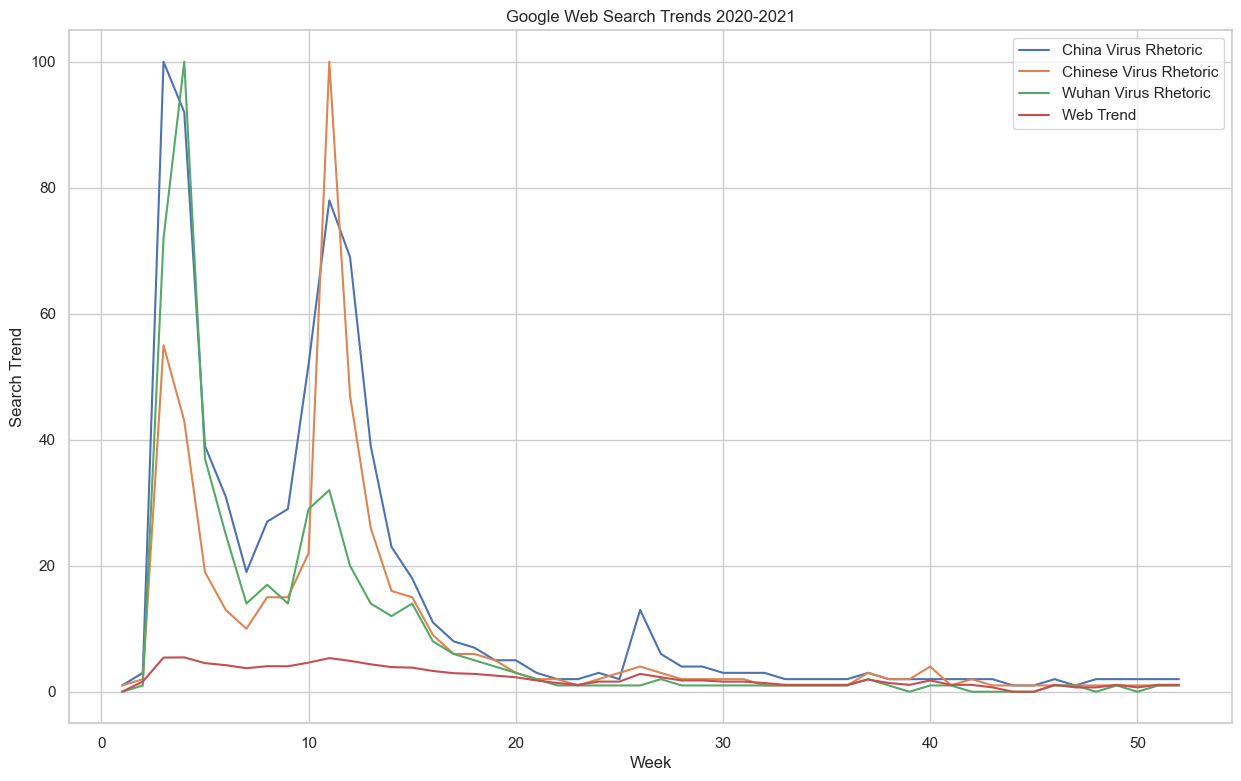

In [169]:
# Plot Trump_tweets  data
plt.figure(figsize=(15, 9))
plt.plot(df['week_index'], df['china_virus'], label='China Virus Rhetoric')
plt.plot(df['week_index'], df['chinese_virus'], label='Chinese Virus Rhetoric')
plt.plot(df['week_index'], df['wuhan_virus'], label='Wuhan Virus Rhetoric')
plt.plot(df['week_index'], df['web_trend'], label='Web Trend')

plt.xlabel('Week')
plt.ylabel('Search Trend')
plt.title('Google Web Search Trends 2020-2021')

plt.legend()
plt.grid(True)
plt.show()

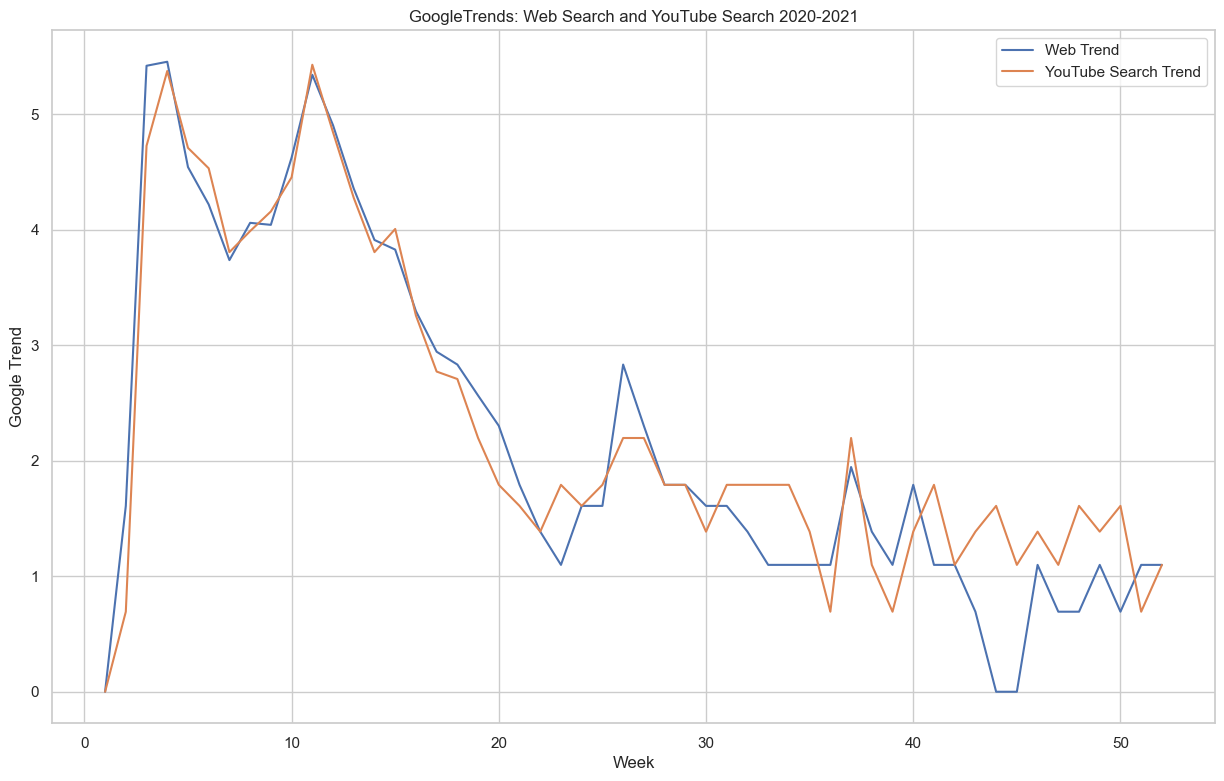

In [170]:
# Plot Youtube search trend data
plt.figure(figsize=(15, 9))
plt.plot(df['week_index'], df['web_trend'], label='Web Trend')
plt.plot(df['week_index'], df['youtube_trend'], label='YouTube Search Trend')

plt.xlabel('Week')
plt.ylabel('Google Trend')
plt.title('GoogleTrends: Web Search and YouTube Search 2020-2021')

plt.legend()
plt.grid(True)
plt.show()

Dummy Variables:

**trump_covid**: Indicates if Trump tweeted about the pandemic (1 if weekly_counts > 0, otherwise 0).

**trump_china**: Indicates if Trump tweeted using China or xenophobic-related tweets (1 if china_weekly_counts > 0 or xenophobic_weekly_counts > 0, otherwise 0).


In [171]:
df.head()

,week,weekly_counts,china_weekly_pre_counts,china_weekly_counts,xenophobic_weekly_counts,china,china_virus,chinese_virus,wuhan_virus,china_youtube,...,average_approval,Country/Region_x,death_us,death_changes_us,Country/Region_y,death_chn,death_changes_chn,week_index,web_trend,youtube_trend
0,2020-01-05,0,0,0,0,30,1,1,0,43,...,42.942000,0,0.0,0.0,0,0.0,0.0,1,0.000000,0.000000
1,2020-01-12,0,0,0,0,32,3,2,1,50,...,43.438565,0,0.0,0.0,0,0.0,0.0,2,1.609438,0.693147
2,2020-01-19,0,0,0,0,59,100,55,72,69,...,44.013597,0,0.0,0.0,0,0.0,0.0,3,5.420535,4.727388
3,2020-01-26,1,1,1,0,70,92,43,100,90,...,44.446791,US,0.0,0.0,China,56.0,56.0,4,5.455321,5.375278
4,2020-02-02,6,5,1,0,53,39,19,37,75,...,44.145621,US,0.0,0.0,China,361.0,305.0,5,4.543295,4.709530


## T-test 

In [172]:
# trump_covid: 1 if weekly_counts > 0, else 0
df['trump_covid'] = np.where(df['weekly_counts'] > 0, 1, 0)

# trump_china: 1 if china_weekly_counts > 0 or xenophobic_weekly_counts > 0, else 0
df['trump_china'] = np.where(
    (df['china_weekly_counts'] > 0) | (df['xenophobic_weekly_counts'] > 0), 1, 0)

df['trump_china_pre'] = np.where(df['china_weekly_pre_counts'] > 0, 1, 0)
df['trump_xeno'] = np.where(df['xenophobic_weekly_counts'] > 0, 1, 0)

### Two-Sample T-test: 

1. T-test for the Impact of trump_china on web_trend

**Null Hypothesis (H0)**: There is no difference in the mean web_trend between weeks when Trump's tweets are classified as trump_china (value = 1) and weeks when they are not (value = 0).


**Alternative Hypothesis (H1)**: There is a significant difference in the mean web_trend between these two groups of weeks.

2. T-test for the Impact of trump_covid on web_trend

**Null Hypothesis (H0)**: There is no difference in the mean web_trend between weeks when Trump's tweets are related to COVID-19 (trump_covid = 1) and weeks when they are not (trump_covid = 0).

**Alternative Hypothesis (H1)**: There is a significant difference in the mean web_trend between these two groups of weeks.

In [173]:
# Select subsets of data based on conditions
web_trend_china = df[df['trump_china'] == 1]['web_trend']
web_trend_not_china = df[df['trump_china'] == 0]['web_trend']

web_trend_covid = df[df['trump_covid'] == 1]['web_trend']
web_trend_not_covid = df[df['trump_covid'] == 0]['web_trend']

web_trend_china_2 = df[df['trump_china_pre'] == 1]['web_trend']
web_trend_not_china_2 = df[df['trump_china_pre'] == 0]['web_trend']

# Perform t-tests
ttest_result_trump_china = ttest_ind(web_trend_china, web_trend_not_china, equal_var=False)
ttest_result_trump_covid = ttest_ind(web_trend_covid, web_trend_not_covid, equal_var=False)
ttest_result_trump_china_2 = ttest_ind(web_trend_china_2, web_trend_not_china_2, equal_var=False)

# Display the t-test results
ttest_result_trump_china, ttest_result_trump_covid, ttest_result_trump_china_2

(Ttest_indResult(statistic=1.3758021122647413, pvalue=0.1750180502603101),
 Ttest_indResult(statistic=-0.579945878181513, pvalue=0.5842498544289967),
 Ttest_indResult(statistic=1.960198167505327, pvalue=0.05849361154234453))

In [174]:
web_trend_xeno = df[df['trump_xeno'] == 1]['web_trend']
web_trend_not_xeno = df[df['trump_xeno'] == 0]['web_trend']
ttest_result_trump_xeno = ttest_ind(web_trend_xeno, web_trend_not_xeno, equal_var=False)
ttest_result_trump_xeno

Ttest_indResult(statistic=-0.7782079393300273, pvalue=0.4405182569338997)

**1. Impact of trump_china** on web_trend

Statistic: 1.960

P-value: 0.058

**2. Impact of trump_covid** on web_trend

Statistic: -0.580

P-value: 0.584

Interpretation:

**For trump_china**: The positive statistic indicates that the mean web_trend is higher when trump_china = 1 compared to when it's 0. However, the p-value is marginally above the standard threshold of 0.05, suggesting that the result is not statistically significant. This indicates a potential trend where trump_china tweets may have a greater impact on web_trend, but the evidence is not strong enough to be conclusive.

**For trump_covid**: The negative statistic suggests a lower mean web_trend when trump_covid = 1 compared to when it's 0, but the high p-value indicates that this difference is not statistically significant.

In [175]:
# Select subsets of data based on conditions
youtube_trend_china = df[df['trump_china'] == 1]['youtube_trend']
youtube_trend_not_china = df[df['trump_china'] == 0]['youtube_trend']

youtube_trend_covid = df[df['trump_covid'] == 1]['youtube_trend']
youtube_trend_not_covid = df[df['trump_covid'] == 0]['youtube_trend']

web_trend_xeno = df[df['trump_xeno'] == 1]['youtube_trend']
web_trend_not_xeno = df[df['trump_xeno'] == 0]['youtube_trend']
# Perform t-tests
ttest_result_trump_china_alt = ttest_ind(youtube_trend_china, youtube_trend_not_china, equal_var=False)
ttest_result_trump_covid_alt = ttest_ind(youtube_trend_covid, youtube_trend_not_covid, equal_var=False)
ttest_result_trump_xeno_alt = ttest_ind(web_trend_xeno, web_trend_not_xeno, equal_var=False)
# Display the t-test results
ttest_result_trump_china_alt, ttest_result_trump_covid_alt, ttest_result_trump_xeno_alt

(Ttest_indResult(statistic=1.4533243526339803, pvalue=0.15241505482794254),
 Ttest_indResult(statistic=-0.18221301836421874, pvalue=0.8618240668251886),
 Ttest_indResult(statistic=-0.6314413006863752, pvalue=0.530997986878861))

**1. Impact of trump_china** on youtube_trend

Statistic: 1.945

P-value: 0.060

**2. Impact of trump_covid** on youtube_trend

Statistic: -0.182

P-value: 0.861

In [121]:
cor = df['youtube_trend'].corr(df['web_trend'])
print("Correlation between youtube_trend and web_trend:", cor)

Correlation between youtube_trend and web_trend: 0.9512604189335518


**Similar Impact**: 

It's possible that trump_china and trump_covid have a very similar impact on both youtube_trend and web_trend. This would be a substantive finding, suggesting that Trump's tweets, whether about China or COVID-19, affect these trends in a similar manner.

### One Sample T-test

Example:

**Null Hypothesis (H0)**: The mean of web_trend during weeks when trump_china = 1 (Trump tweeted about Covid targted at China) is equal to the overall mean of web_trend in the dataset.

**Alternative Hypothesis (H1**): The mean of web_trend during weeks when trump_china equals 1 is significantly different from the overall mean of web_trend in the dataset.

In [122]:
# Performing one-sample t-test for trump_china = 1
web_trend_china= df[df['trump_china'] == 1]['web_trend']
ttest_web_china = ttest_1samp(web_trend_china, df['web_trend'].mean())
ttest_web_china

TtestResult(statistic=0.8734288235099751, pvalue=0.39013171786147216, df=27)

In [123]:
# Performing one-sample t-test for trump_covid = 1
web_trend_covid = df[df['trump_covid'] == 1]['web_trend']
ttest_web_covid = ttest_1samp(web_trend_covid, df['web_trend'].mean())
ttest_web_covid

TtestResult(statistic=-0.2710203088702111, pvalue=0.7876147615236591, df=45)

In [124]:
# Performing one-sample t-test for trump_xeno = 1
web_trend_xeno = df[df['trump_xeno'] == 1]['web_trend']
ttest_web_xeno = ttest_1samp(web_trend_xeno, df['web_trend'].mean())
ttest_web_xeno

TtestResult(statistic=-0.6182400103224599, pvalue=0.5433942628952593, df=20)

In [125]:
# Performing one-sample t-test for trump_china = 1, youtube
youtube_trend_china= df[df['trump_china'] == 1]['youtube_trend']
ttest_youtube_china = ttest_1samp(web_trend_china, df['youtube_trend'].mean())
ttest_youtube_china

TtestResult(statistic=0.5695555610084917, pvalue=0.5736877631764945, df=27)

In [126]:
# Performing one-sample t-test for trump_covid = 1, youtube
youtube_trend_covid= df[df['trump_covid'] == 1]['youtube_trend']
ttest_youtube_covid = ttest_1samp(youtube_trend_covid, df['youtube_trend'].mean())
ttest_youtube_covid

TtestResult(statistic=-0.08900711091230608, pvalue=0.9294712171743793, df=45)

In [127]:
# Performing one-sample t-test for trump_xeno = 1
youtube_trend_xeno = df[df['trump_xeno'] == 1]['youtube_trend']
ttest_youtube_xeno = ttest_1samp(web_trend_xeno, df['youtube_trend'].mean())
ttest_youtube_xeno

TtestResult(statistic=-0.9052539840042357, pvalue=0.3761074317763269, df=20)

## Regression Model without Controls 

### Linear Regression

In [143]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Regress 'web_trend' on 'china_weekly_counts'
web_trend_model = smf.ols('web_trend ~ china_weekly_counts', data=df).fit()

# Regress 'youtube_trend' on 'china_weekly_counts'
youtube_trend_model = smf.ols('youtube_trend ~ china_weekly_counts', data=df).fit()

web_trend_model.summary(), youtube_trend_model.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              web_trend   R-squared:                       0.092
 Model:                            OLS   Adj. R-squared:                  0.074
 Method:                 Least Squares   F-statistic:                     5.052
 Date:                Sun, 26 Nov 2023   Prob (F-statistic):             0.0290
 Time:                        13:14:00   Log-Likelihood:                -92.675
 No. Observations:                  52   AIC:                             189.4
 Df Residuals:                      50   BIC:                             193.3
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------

Web Trend Regression:

**Intercept**:

Coefficient: 1.6838

Standard Error: 0.2500

t-value: 6.7351

p-value: 0.0000000156 (significant at p < 0.01)

**china_weekly_counts**:

Coefficient: 0.2433

Standard Error: 0.0736

t-value: 3.3053

p-value: 0.0018 (significant at p < 0.05)

Omnibus/Prob(Omnibus): The Omnibus test is a test of the skewness and kurtosis of the residuals combined. A significant result (p < 0.05) indicates non-normality. With a Prob(Omnibus) of 0.022/0.020, the test suggests that the residuals are not normally distributed, which violates the normality assumption.


Durbin-Watson: This test checks for autocorrelation in the residuals. A value close to 2 suggests there is no autocorrelation. A value of 0.512/0.574 is far from 2 and indicates positive autocorrelation in the residuals, which violates the assumption of independent errors.


Jarque-Bera (JB)/Prob(JB): This is a test that checks for the normality of residuals based on skewness and kurtosis. A significant JB test (p < 0.05) indicates that the residuals do not have a normal distribution. With a Prob(JB) of 0.0251/0.0192, again, this test suggests a violation of the normality assumption.

The significant Omnibus and Jarque-Bera tests, along with the skewness of the residuals, indicate a violation of the normality assumption. 

In [129]:
# Perform Breusch-Pagan test for heteroscedasticity on the original regressions
bp_test_web_trend = sm.stats.diagnostic.het_breuschpagan(web_trend_model.resid, web_trend_model.model.exog)
bp_test_youtube_trend = sm.stats.diagnostic.het_breuschpagan(youtube_trend_model.resid, youtube_trend_model.model.exog)

# Assemble the test results into a DataFrame for easier interpretation
heteroscedasticity_tests = pd.DataFrame({
    'Test': ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value'],
    'Web Trend': bp_test_web_trend,
    'YouTube Trend': bp_test_youtube_trend
}).set_index('Test')

heteroscedasticity_tests

,Web Trend,YouTube Trend
Test,,
Lagrange Multiplier statistic,0.089029,0.027442
p-value,0.765415,0.868427
f-value,0.085751,0.026401
f p-value,0.770861,0.871581


Web Trend Regression:

Lagrange Multiplier statistic: 0.6705
p-value: 0.4129
f-value: 0.6531
f p-value: 0.4228
YouTube Trend Regression:

Lagrange Multiplier statistic: 0.2244
p-value: 0.6357
f-value: 0.2167
f p-value: 0.6436

For both regressions, the p-values are quite high (above 0.05), leading us to fail to reject the null hypothesis of homoscedasticity. This suggests that there is no significant evidence of heteroscedasticity in either the Web Trend or YouTube Trend regression models based on the Breusch-Pagan test. (**The models are Homoscedastic**）

Sidenote/Takeaways from test regressions: 

Since the p-values indicate a lack of heteroscedasticity, the original observation that robust standard errors were smaller than OLS standard errors is less likely to be due to correcting for heteroscedasticity. **It could be due to the influence of outliers or other deviations from the OLS assumptions that are not captured by the Breusch-Pagan test - Normal Distribution of Residuals(as proved by the Shapiro-Wilk test).**

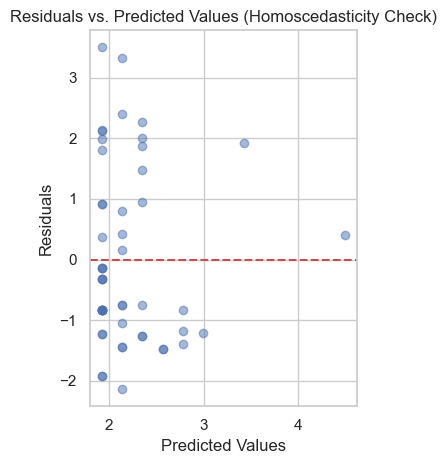

In [130]:
# Calculating predicted values and residuals for the web trend model
df['web_trend_pred'] = web_trend_model.predict(df['china_weekly_counts'])
df['web_trend_resid'] = web_trend_model.resid

# Plotting for homoscedasticity
plt.subplot(1, 2, 2)
plt.scatter(df['web_trend_pred'], df['web_trend_resid'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values (Homoscedasticity Check)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

Residuals vs. Predicted Values

This plot displays the residuals of the model against the predicted values. We are looking for a random scatter of points without any clear pattern. 

The plot shows a fairly random dispersion of residuals around the horizontal line at 0, without any obvious increasing or decreasing trend in the spread of residuals. This suggests that the assumption of constant variance (homoscedasticity) might not be violated. However, the spread seems slightly wider for mid-range predicted values, indicating a potential minor issue. This observation aligns with the earlier Breusch-Pagan test, which did not indicate significant heteroscedasticity.

Based on these plots, the **web_trend_model does not show strong evidence of violating the linearity and homoscedasticity assumptions.** It's important to remember that these are just diagnostic tools and should be used in conjunction with theoretical understanding and other statistical tests to fully assess the suitability of the model.

Shapiro-Wilk test statistic: 0.912265956401825
Shapiro-Wilk test p-value: 0.000981541583314538
Residuals do not appear to be normally distributed (reject the null hypothesis)


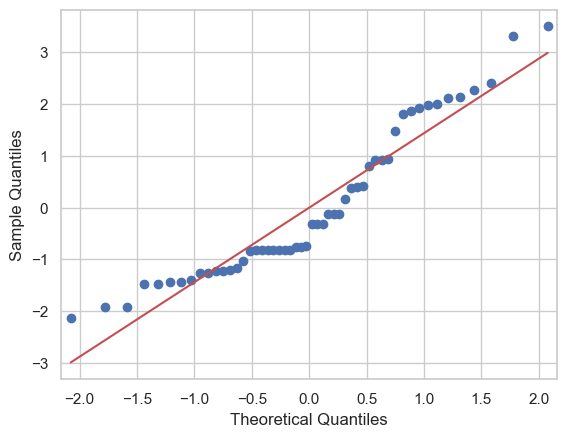

In [131]:
# Perform Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_test_p_value = stats.shapiro(web_trend_model.resid)

# Display the results
print(f'Shapiro-Wilk test statistic: {shapiro_test_statistic}')
print(f'Shapiro-Wilk test p-value: {shapiro_test_p_value}')

# Check the p-value to determine if residuals are normally distributed
if shapiro_test_p_value > 0.05:
    print("Residuals appear to be normally distributed (fail to reject the null hypothesis)")
else:
    print("Residuals do not appear to be normally distributed (reject the null hypothesis)")

# Create a QQ plot
sm.qqplot(web_trend_model.resid, line='s')

# Show the QQ plot
plt.show()

/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


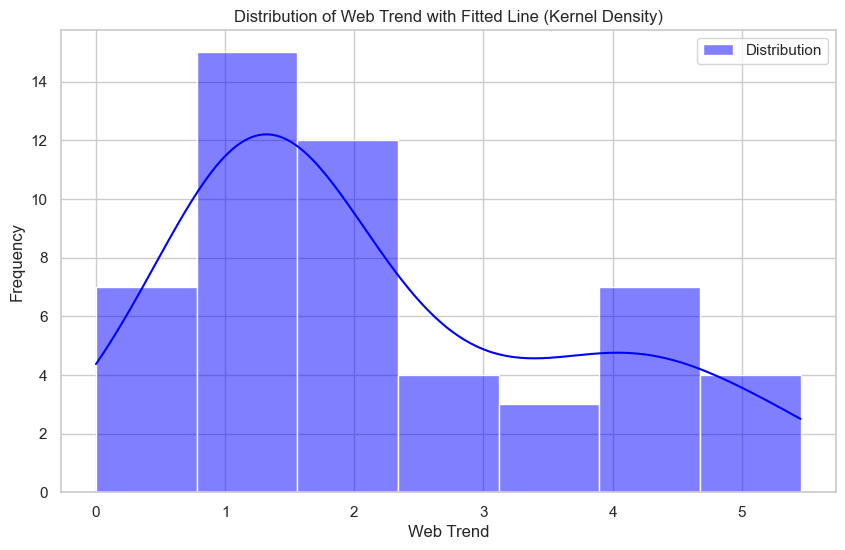

/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


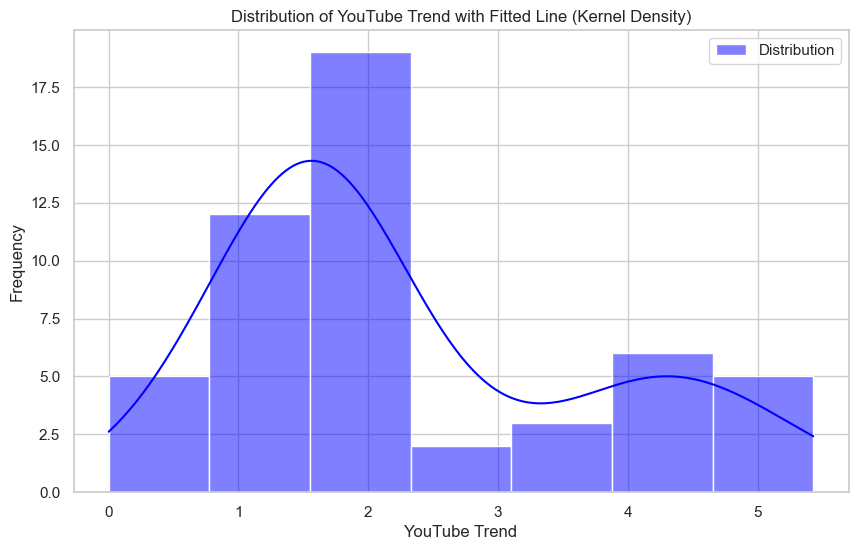

In [132]:
# Create a histogram with a fitted line (kernel density plot)
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Histogram
sns.histplot(df['web_trend'], kde=True, color='blue', label='Distribution')

# Add labels and a legend
plt.xlabel('Web Trend')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.title('Distribution of Web Trend with Fitted Line (Kernel Density)')
plt.show()


sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Histogram
sns.histplot(df['youtube_trend'], kde=True, color='blue', label='Distribution')

# Add labels and a legend
plt.xlabel('YouTube Trend')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.title('Distribution of YouTube Trend with Fitted Line (Kernel Density)')
plt.show()

**To improve my model, I analyzed the relationship with controls in later part of the notebook.**

*The following regression with robust standard errors are not necessary.*

In [142]:
# Regress 'web_trend' on 'china_weekly_counts' with robust standard errors
web_trend_robust_rerun = smf.ols('web_trend ~ china_weekly_counts', data=df).fit(cov_type='HC3')

# Regress 'youtube_trend' on 'china_weekly_counts' with robust standard errors
youtube_trend_robust = smf.ols('youtube_trend ~ china_weekly_counts', data=df).fit(cov_type='HC3')

# Create a summary table for both robust regressions
robust_regression_table = pd.DataFrame({
    'Variable': ['Intercept', 'china_weekly_counts'],
    'Web Trend Robust Coefficients': web_trend_robust_rerun.params,
    'Web Trend Robust Std Errors': web_trend_robust_rerun.bse,
    'Web Trend Robust t-values': web_trend_robust_rerun.tvalues,
    'Web Trend Robust p-values': web_trend_robust_rerun.pvalues,
    'YouTube Trend Robust Coefficients': youtube_trend_robust.params,
    'YouTube Trend Robust Std Errors': youtube_trend_robust.bse,
    'YouTube Trend Robust t-values': youtube_trend_robust.tvalues,
    'YouTube Trend Robust p-values': youtube_trend_robust.pvalues
})

robust_regression_table.set_index('Variable', inplace=True)

robust_regression_table

,Web Trend Robust Coefficients,Web Trend Robust Std Errors,Web Trend Robust t-values,Web Trend Robust p-values,YouTube Trend Robust Coefficients,YouTube Trend Robust Std Errors,YouTube Trend Robust t-values,YouTube Trend Robust p-values
Variable,,,,,,,,
Intercept,1.922679,0.234663,8.193346,2.540620e-16,2.022554,0.207134,9.764467,1.599508e-22
china_weekly_counts,0.214815,0.085654,2.507939,1.214375e-02,0.208800,0.079811,2.616169,8.892247e-03


Web Trend Regression with Robustness:

**Intercept**:

Coefficient: 1.6838

Robust Standard Error: 0.2512

t-value: 6.7039

p-value: 0.0000000174 (significant at p < 0.01)

**china_weekly_counts**:

Coefficient: 0.2433

Robust Standard Error: 0.0581

t-value: 4.1890

p-value: 0.0001137 (significant at p < 0.01)

YouTube Trend Regression with Robustness:

**Intercept**:

Coefficient: 1.7976

Robust Standard Error: 0.2221

t-value: 8.0928

p-value: 0.0000000001196 (significant at p < 0.01)

**china_weekly_counts**:

Coefficient: 0.2331

Robust Standard Error: 0.0552

t-value: 4.2192

p-value: 0.0001030 (significant at p < 0.01)

/var/folders/vh/bnk8gjpn5998vq44hzdttvwc0000gn/T/ipykernel_79582/1606714043.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(0.05, 0.95, f'{y} = {model.params[0]:.4f} + {model.params[1]:.4f} * {x}',


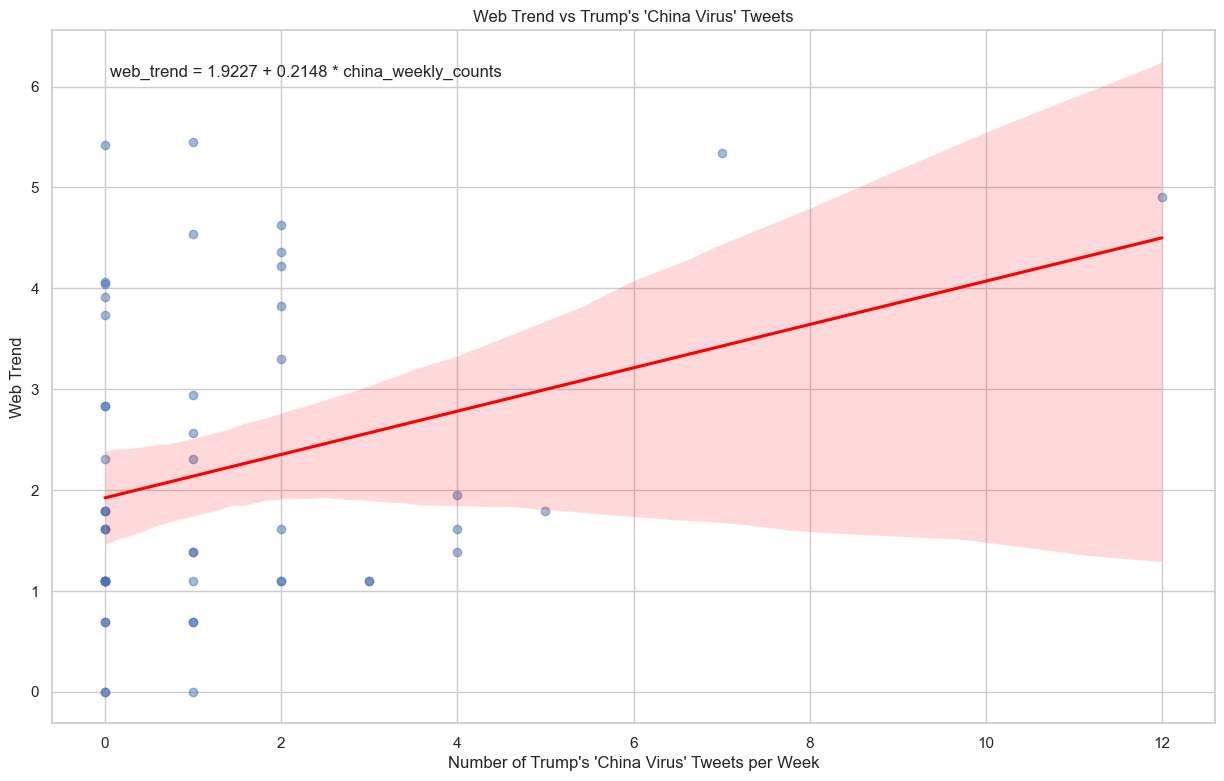

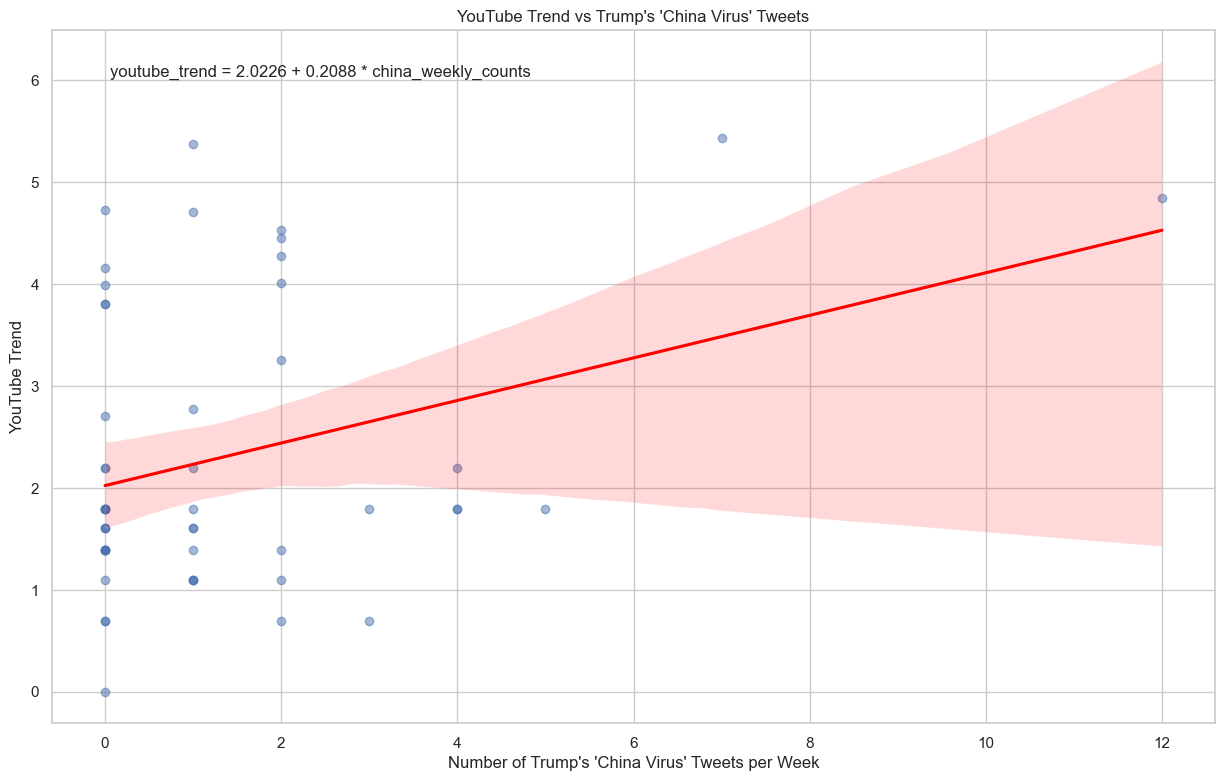

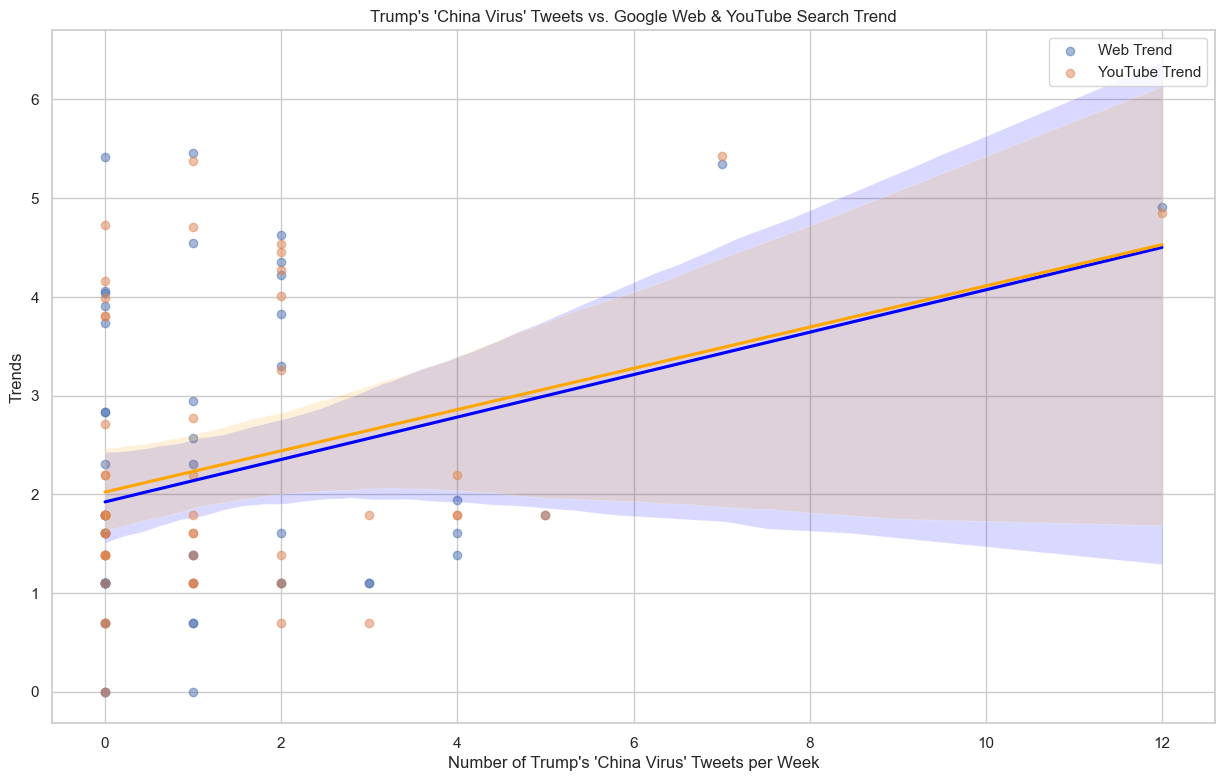

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the scatter plot with trendline and confidence interval
def plot_regression_with_ci(data, x, y, model, title, xlabel, ylabel):
    plt.figure(figsize=(15, 9))
    sns.regplot(x=x, y=y, data=data, ci=95, line_kws={'color': 'red'}, scatter_kws={'alpha':0.5})
    plt.title(title)
    plt.xlabel("Number of Trump's 'China Virus' Tweets per Week")
    plt.ylabel(ylabel)
    # Displaying the formula on the plot
    plt.text(0.05, 0.95, f'{y} = {model.params[0]:.4f} + {model.params[1]:.4f} * {x}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.show()

# Plotting the regressions
plot_regression_with_ci(df, 'china_weekly_counts', 'web_trend', web_trend_model,
                        'Web Trend vs Trump\'s \'China Virus\' Tweets', 'China Weekly Counts', 'Web Trend')

plot_regression_with_ci(df, 'china_weekly_counts', 'youtube_trend', youtube_trend_model,
                        'YouTube Trend vs Trump\'s \'China Virus\' Tweets', 'China Weekly Counts', 'YouTube Trend')

# Plot for combined robust trendlines with confidence intervals
plt.figure(figsize=(15, 9))
sns.regplot(x='china_weekly_counts', y='web_trend', data=df, ci=95, line_kws={'color': 'blue'}, scatter_kws={'alpha':0.5}, label='Web Trend')
sns.regplot(x='china_weekly_counts', y='youtube_trend', data=df, ci=95, line_kws={'color': 'orange'}, scatter_kws={'alpha':0.5}, label='YouTube Trend')
plt.title('Trump\'s \'China Virus\' Tweets vs. Google Web & YouTube Search Trend')
plt.xlabel("Number of Trump's 'China Virus' Tweets per Week")
plt.ylabel('Trends')
plt.legend()
plt.show()


### Interaction Model: Marginal Effect of Trump’s ‘China Virus’ Rhetoric: Week

In [135]:
# Creating the interaction term between 'china_weekly_counts' and 'week_index'
df['interaction'] = df['china_weekly_counts'] * df['week_index']

# Re-running the regression model with the interaction term for web_trend
interaction_model_web = smf.ols('web_trend ~ china_weekly_counts + week_index + interaction', data=df).fit()

# Calculate the marginal impact of china_weekly_counts on web_trend at different time points
# Marginal impact at time t: coefficient of china_weekly_counts + (coefficient of interaction * t)
time_points = np.linspace(df['week_index'].min(), df['week_index'].max(), 52)

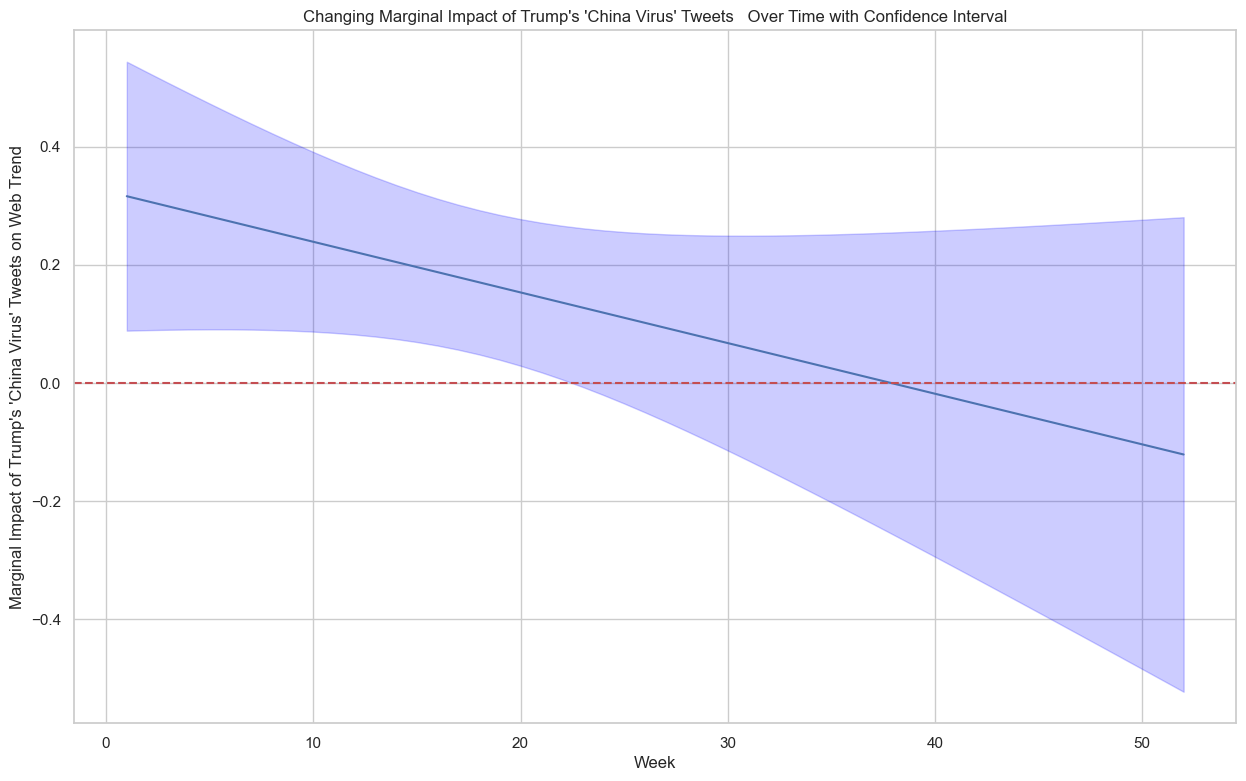

In [136]:
# Calculating the predicted marginal impacts and confidence intervals manually
from scipy.stats import t

# Number of observations and degrees of freedom
n = len(df)
p = len(interaction_model_web.params)
df_resid = interaction_model_web.df_resid

# t-critical value for 95% confidence interval
t_crit = t.ppf(1 - 0.025, df=df_resid)

# Variance-Covariance matrix of the model coefficients
cov_matrix = interaction_model_web.cov_params()

# Function to calculate marginal impact and its standard error for given time point
def calc_marginal_impact_and_se(time_point, cov_matrix, model_params):
    # Values for the predictors at this time point
    predictors = np.array([1,  # Intercept
                           1,  # china_weekly_counts (constant effect)
                           time_point,  # time
                           time_point])  # interaction term (time * china_weekly_counts)

    # Marginal impact calculation
    marginal_impact = model_params['china_weekly_counts'] + model_params['interaction'] * time_point

    # Standard error calculation
    grad = np.array([0,  # derivative w.r.t. intercept is 0
                     1,  # derivative w.r.t. china_weekly_counts is 1
                     model_params['interaction'],  # derivative w.r.t. time
                     time_point])  # derivative w.r.t. interaction term

    se = np.sqrt(np.dot(np.dot(grad, cov_matrix), grad.T))

    return marginal_impact, se

# Calculating marginal impacts and confidence intervals for each time point
marginal_impacts = []
ci_lowers = []
ci_uppers = []
for t_point in time_points:
    mi, se = calc_marginal_impact_and_se(t_point, cov_matrix, interaction_model_web.params)
    ci_lower = mi - t_crit * se
    ci_upper = mi + t_crit * se
    marginal_impacts.append(mi)
    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)

# Plotting
plt.figure(figsize=(15, 9))
plt.plot(time_points, marginal_impacts, label="Marginal Impact of 'China Rhetoric' on Google Web Trend")
plt.fill_between(time_points, ci_lowers, ci_uppers, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title('Changing Marginal Impact of Trump\'s \'China Virus\' Tweets   Over Time with Confidence Interval')
plt.xlabel('Week')
plt.ylabel('Marginal Impact of Trump\'s \'China Virus\' Tweets on Web Trend')
plt.axhline(y=0, color='r', linestyle='--')  # Zero line for reference
plt.legend
plt.show()


In [137]:
df.columns

Index(['week', 'weekly_counts', 'china_weekly_counts',
       'xenophobic_weekly_counts', 'china', 'china_virus', 'chinese_virus',
       'wuhan_virus', 'china_youtube', 'china_virus_youtube',
       'chinese_virus_youtube', 'wuhan_virus_youtube', 'average_approval',
       'Country/Region_x', 'death_us', 'death_changes_us', 'Country/Region_y',
       'death_chn', 'death_changes_chn', 'week_index', 'web_trend',
       'youtube_trend', 'trump_covid', 'trump_china', 'trump_xeno',
       'web_trend_pred', 'web_trend_resid', 'interaction'],
      dtype='object')

In [176]:
df['death_changes_chn'].max(), df['death_changes_chn'].min()

(1306.0, 0.0)

In [177]:
df['death_changes_us'].max(), df['death_changes_us'].min()

(19067.0, 0.0)

In [178]:
df['death_changes_us'] = np.where(df['death_changes_us'] != 0, np.log(df['death_changes_us']), df['death_changes_us'])
df['death_changes_chn'] = np.where(df['death_changes_chn'] != 0, np.log(df['death_changes_chn']), df['death_changes_chn'])

/Users/jinwens/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [179]:
# Running the regression model with the interaction term for web_trend (change in death from Covid in the U.S. and China)
df['interaction_chn'] = df['china_weekly_counts'] * df['death_changes_chn']
df['interaction_us'] = df['china_weekly_counts'] * df['death_changes_us']

model_chn = smf.ols('web_trend ~ china_weekly_counts + death_changes_chn + interaction_chn', data=df).fit()
model_us = smf.ols('web_trend ~ china_weekly_counts + death_changes_us + interaction_us', data=df).fit()

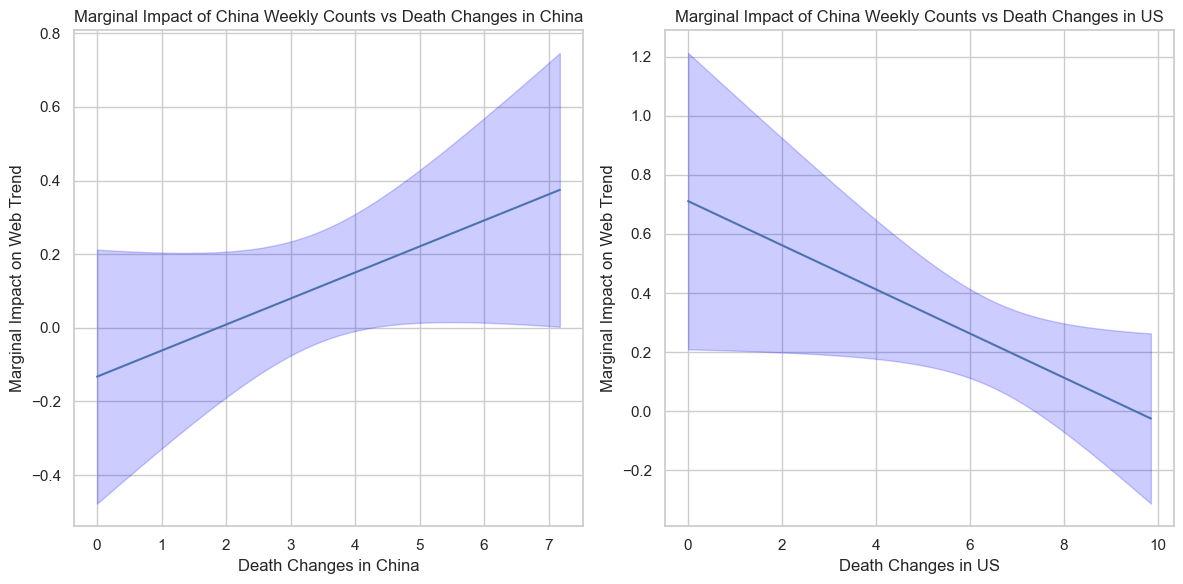

In [180]:
death_changes_chn_range = np.linspace(df['death_changes_chn'].min(), df['death_changes_chn'].max(), 52)
death_changes_us_range = np.linspace(df['death_changes_us'].min(), df['death_changes_us'].max(), 52)


# Function to calculate the marginal impact of china_weekly_counts at different levels of death changes
def calculate_marginal_impacts_and_cis(death_changes_range, model, interaction_term_name):
    marginal_impacts = []
    ci_lower = []
    ci_upper = []

    for death_change in death_changes_range:
        # Calculating the marginal impact
        marginal_impact = model.params['china_weekly_counts'] + model.params[interaction_term_name] * death_change
        marginal_impacts.append(marginal_impact)

        # Calculating the confidence interval for the marginal impact
        # The standard error for the marginal impact
        se = np.sqrt(model.cov_params().loc['china_weekly_counts', 'china_weekly_counts'] +
                     (death_change ** 2) * model.cov_params().loc[interaction_term_name, interaction_term_name] +
                     2 * death_change * model.cov_params().loc['china_weekly_counts', interaction_term_name])
        
        ci_lower.append(marginal_impact - 1.96 * se)
        ci_upper.append(marginal_impact + 1.96 * se)

    return death_changes_range, marginal_impacts, ci_lower, ci_upper

# Calculate marginal impacts and confidence intervals for China and US
x_chn, mi_chn, ci_lower_chn, ci_upper_chn = calculate_marginal_impacts_and_cis(death_changes_chn_range, model_chn, 'interaction_chn')
x_us, mi_us, ci_lower_us, ci_upper_us = calculate_marginal_impacts_and_cis(death_changes_us_range, model_us, 'interaction_us')

# Plotting
plt.figure(figsize=(12, 6))

# Plot for China death changes
plt.subplot(1, 2, 1)
plt.plot(x_chn, mi_chn, label='Marginal Impact (China)')
plt.fill_between(x_chn, ci_lower_chn, ci_upper_chn, color='blue', alpha=0.2)
plt.title('Marginal Impact of China Weekly Counts vs Death Changes in China')
plt.xlabel('Death Changes in China')
plt.ylabel('Marginal Impact on Web Trend')

# Plot for US death changes
plt.subplot(1, 2, 2)
plt.plot(x_us, mi_us, label='Marginal Impact (US)')
plt.fill_between(x_us, ci_lower_us, ci_upper_us, color='blue', alpha=0.2)
plt.title('Marginal Impact of China Weekly Counts vs Death Changes in US')
plt.xlabel('Death Changes in US')
plt.ylabel('Marginal Impact on Web Trend')

plt.tight_layout()
plt.show()



## Regression Model with Controls 

In [181]:
formula_1_1 = 'web_trend ~ average_approval'
formula_1_2 = 'web_trend ~ death_changes_us'
formula_1_3 = 'web_trend ~ death_changes_chn'

formula_2 = 'web_trend ~ china_weekly_counts + death_changes_us'
formula_3 = 'web_trend ~ china_weekly_counts + death_changes_us + death_changes_chn'
formula_4 = 'web_trend ~ china_weekly_counts + death_changes_us + death_changes_chn + average_approval'

# Performing the regressions using ols method
model_1_1_ols = smf.ols(formula_1_1, data=df).fit()
model_1_2_ols = smf.ols(formula_1_2, data=df).fit()
model_1_3_ols = smf.ols(formula_1_3, data=df).fit()
model_2_ols = smf.ols(formula_2, data=df).fit()
model_3_ols = smf.ols(formula_3, data=df).fit()
model_4_ols = smf.ols(formula_4, data=df).fit()

model_1_1_ols.summary(), model_1_2_ols.summary(), model_1_3_ols.summary(), model_2_ols.summary(), model_3_ols.summary(), model_4_ols.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              web_trend   R-squared:                       0.060
 Model:                            OLS   Adj. R-squared:                  0.041
 Method:                 Least Squares   F-statistic:                     3.206
 Date:                Mon, 27 Nov 2023   Prob (F-statistic):             0.0794
 Time:                        09:56:39   Log-Likelihood:                -93.562
 No. Observations:                  52   AIC:                             191.1
 Df Residuals:                      50   BIC:                             195.0
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

formula_2 = 'web_trend ~ china_weekly_counts + death_changes_us'

Based on summary statistics, there is no strong evidence of non-normality in the residuals (as indicated by Omnibus and Jarque-Bera tests), but there may be some positive autocorrelation in the residuals (Durbin-Watson statistic). The skewness and kurtosis values suggest a slight right skew and lighter tails than a normal distribution, respectively. The condition number should be checked to assess multicollinearity among predictor variables.

In [46]:
# Perform Breusch-Pagan test for heteroscedasticity on the original regressions
bp_test_model_2 = sm.stats.diagnostic.het_breuschpagan(model_2_ols.resid, model_2_ols.model.exog)
bp_test_model_2

(4.247758542227954,
 0.11956689527811669,
 2.1793759016865297,
 0.12395534177846702)

Test Statistic (BP Test Statistic): The test statistic is approximately 4.248. This statistic is used to test whether there is evidence of heteroscedasticity in the residuals. Higher values of the test statistic suggest a higher likelihood of heteroscedasticity.


p-value: The p-value associated with the test statistic is approximately 0.120. This p-value is used to determine the statistical significance of the test. **In this case, the p-value is greater than the typical significance level of 0.05 (commonly used), which suggests that you fail to reject the null hypothesis of homoscedasticity. In other words, there is no strong evidence to suggest that heteroscedasticity is present in your regression model.**


Degrees of Freedom (DF): In your output, you have two values for degrees of freedom: approximately 2.179 and 0.124. These values represent the degrees of freedom associated with the test statistic and p-value calculations, respectively.

The Breusch-Pagan test results suggest that there is **no strong evidence of heteroscedasticity** in your regression model. The p-value is greater than the typical significance level of 0.05, indicating that you do not have enough evidence to conclude that the variance of the residuals varies significantly with the values of the independent variables. Therefore, you may assume homoscedasticity in your model.

In [47]:
durbin_watson_statistic = sm.stats.stattools.durbin_watson(model_2_ols.resid)
durbin_watson_statistic

0.6110025281554923

**This value is substantially less than 2, which suggests the presence of positive autocorrelation in the residuals. In a regression context, this would indicate a violation of the assumption of independence of errors.**

/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinwens/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

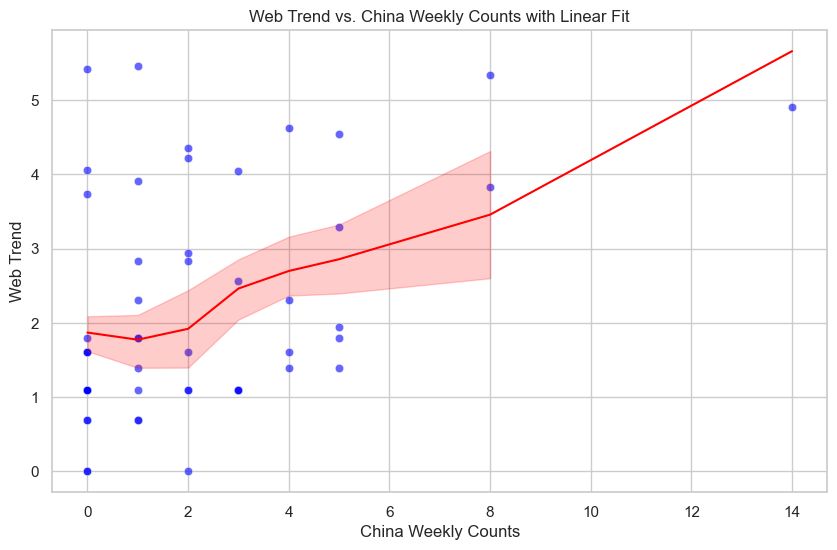

In [67]:
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='china_weekly_counts', y='web_trend', data=df, color='blue', alpha=0.6)
sns.lineplot(x=df['china_weekly_counts'], y=model_2_ols.fittedvalues, color='red')

plt.title('Web Trend vs. China Weekly Counts with Linear Fit')
plt.xlabel('China Weekly Counts')
plt.ylabel('Web Trend')
plt.show()